# Linear Regression as a Machine Learning Model
In this notebook, we will consider linear regression and how it might be approached as a machine learning model.

**Learning Objectives**

At the end of this notebook, you should be able to
1. envision linear regression as an iterative process.
2. define the mean square error cost function and compute its gradient
3. describe how gradient descent is used to final optimal model parameters.

**Import modules**

Begin by importing the modules to be used in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Linear Regression
In its simplest form, linear regression refers to fitting a simple line to data. In our early math classes, we learn that a line has the following form:

$$
y = mx+b
$$

where $x$ is some independent data, $y$ is some dependent data, $m$ is the slope and $b$ is the intercept. 

For a concrete example, we will consider the trend in CO$_2$ concentration in the atmosphere as measured at the Mauna Loa Observatory on the Mauna Loa volcano in Hilo Hawaii:


<img src="Mauna_Loa_Observatory.jpg" alt="Mauna Loa Observatory" width="500">

Photo Credit: Johnathon Kingston, [National Geographic](https://education.nationalgeographic.org/resource/mauna-loa-observatory/).


The record of CO$_2$ concentration collected at Mauna Loa, sometimes referred to as the "Keeling Curve" for its founding scientist, is a multi-decadal record that is available from the Scripps Institute of Oceanography [HERE](https://keelingcurve.ucsd.edu/). The video [HERE](https://youtu.be/dXBzFNEwoj8) for information on how the data is collected.

Here, we will work the monthly data in this dataset, which is available in the `monthly_in_situ_co2_mlo.csv` file. Let's read that in here:

In [3]:
# read in the dataset with pandas
df = pd.read_csv('monthly_in_situ_co2_mlo.csv', skiprows=64)

# filter out null values stored as -99
df = df[df.iloc[:, 4] >0]

# the decimal year information is in the 4th column
x = df.iloc[:, 3]

# the CO2 information is in the 5th column
y = df.iloc[:, 4]

Let's take a look at what this data looks like:

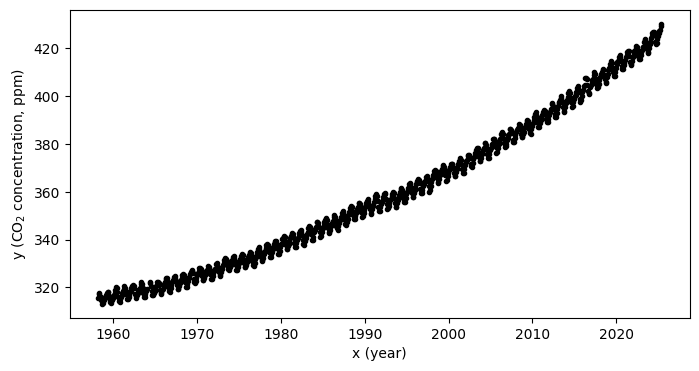

In [4]:
plt.figure(figsize=(8,4))
plt.plot(x,y,'k.')
plt.xlabel('x (year)')
plt.ylabel('y (CO$_2$ concentration, ppm)')
plt.show()

Interesting! There's a lot going on in this plot. For the purposes of this demo, let's subset our data to be during the period 2010-2020 (don't worry, we'll come back to the full dataset in a subsequent next notebook). 

In [5]:
# subset to a given time range
df_subset = df[(x>=2010) & (x<=2020)]

# redefine x and y
x = np.array(df_subset.iloc[:,3])
y = np.array(df_subset.iloc[:,4])

# remove the first value of y
x = x-2010
y = y-y[0]

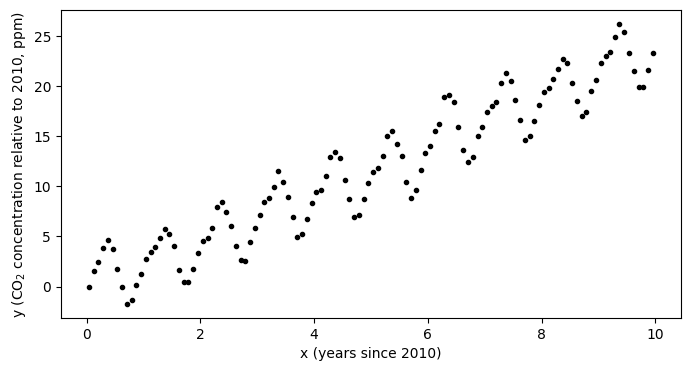

In [6]:
plt.figure(figsize=(8,4))
plt.plot(x,y,'k.')
plt.xlabel('x (years since 2010)')
plt.ylabel('y (CO$_2$ concentration relative to 2010, ppm)')
plt.show()

Visually looking at the data, we can see that the curve has a faily consistent upward trend amid a seasonal trend. One question we may be interested in is: how much has the CO$_2$ concentration been increasing each year?

## Linear Regression with `numpy`

We can fit a polynomial to this data using `numpy` as follows to find the slope of the line of best fit:

In [7]:
p = np.polyfit(x, y, deg=1)
m = p[0]
b = p[1]
print('Intercept: ', b)
print('Slope: ', m)

Intercept:  -0.13938865815023277
Slope:  2.368187875634491


This slope defines the rate of increase each year - here we estimate that on average during 2010-2020, the rate of increase was about 2.37 ppm/year.

We can plot the model on an independent x-axis as follows:

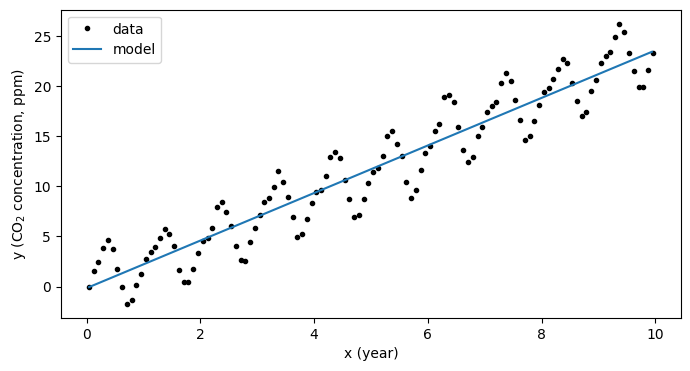

In [8]:
# define a model mx+b and apply it over the range of data values
model_x = np.arange(np.min(x), np.max(x), 0.1)
model_y = m * model_x + b

# recreate the plot with the line of best fit
plt.figure(figsize=(8,4))
plt.plot(x,y,'k.',label='data')
plt.plot(model_x, model_y,label='model')
plt.xlabel('x (year)')
plt.ylabel('y (CO$_2$ concentration, ppm)')
plt.legend(loc=2)
plt.show()

### The mechanics of linear regression

Neat - we can pretty easily fit a line to some data. But what happened under the hood?

In this process, `numpy` has minimized the error between the points and the line to find the best estimates of the slope $m$ and the slope $b$. In most math textbooks, the error between the data and model is referred to as a "cost function" and, in this case, is given as

$$
 J = \frac{1}{N} \sum_{i=1}^N (y_{data,i} - y_{model,i})^2
$$

This formula is called the **Mean Squared Error** (MSE) since, well, it is the mean of the errors squared.

We can code this up as function using `numpy` as:

In [12]:
# define the cost function here
def cost_function(y_data, y_model):
    N = len(y_data)
    mean_squared_error = (1 / N) * np.sum((y_data - y_model) ** 2)
    return mean_squared_error

Using the above cost function, we can compute and visualize the "error space" -- the cost between data and model for a range of the parameters $m$ and $b$.

In [13]:
intercept_space = np.linspace(-20,20,200)
slope_space = np.linspace(0,5,200)
I, S = np.meshgrid(intercept_space, slope_space)
Error = np.zeros((200,200))

# fill in the error matrix
for row in range(np.shape(I)[0]):
    for col in range(np.shape(S)[1]):
        Error[row,col] = cost_function(y, I[row,col]+S[row,col]*x)

Then, we can visualize our best estimate on this error space:

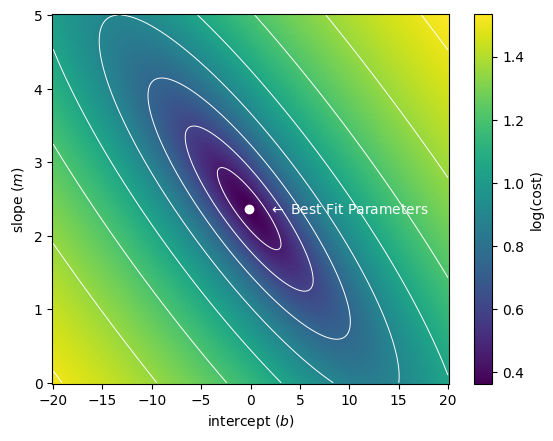

In [14]:
C = plt.pcolormesh(intercept_space,slope_space, np.log10(np.sqrt(Error)))
plt.contour(intercept_space,slope_space, np.log10(np.sqrt(Error)),colors='white',linewidths=0.7)
plt.plot(b, m, 'wo')
plt.text(b+2, m, '$\\leftarrow$ Best Fit Parameters',color='white',va='center')
plt.colorbar(C, label='log(cost)')
plt.xlabel('intercept ($b$)')
plt.ylabel('slope ($m$)')
plt.show()

As we can see, out best fit parameters are those which minimize the error. But how does this work?

### Computing the minimum of the cost function

In the above example, we visualized the error for a relatively large range of slope and intercept values - we might refer to this as the "brute force" method. This is possible because we have a very simple model and a simple cost function. 

To see how the solution is computed, first we need to consider how the problem could be formulated as a matrix set of equations. Note that in this process, we are looking for values $b$ and $m$ such that the difference between model values $\hat{y}$ and data values $y$ are minimimized. The model values are given by the following set of equations for our $N$ input data values:

$$
\begin{align*}
\hat{y}_1 & = m x_1 + b \\ 
\hat{y}_2 & = m x_2 + b \\ 
&\vdots \\
\hat{y}_N & = m x_N + b \\ 
\end{align*}
$$

We can organize in a vector format as follows:

$$
\begin{bmatrix} \hat{y}_1 \\ \hat{y}_2 \\ \vdots \\ \hat{y}_N \end{bmatrix} = m \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_N \end{bmatrix} + b\begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}\\
$$

Using a boldface notation for vectors, we might also write this as

$$
\hat{\textbf{y}} = m \textbf{x} + b
$$

However, we can also go one step further to utilize the dot product notation:

$$
\hat{\textbf{y}} = \begin{bmatrix} \hat{y}_1 \\ \hat{y}_2 \\ \vdots \\ \hat{y}_N \end{bmatrix} = m \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_N \end{bmatrix} + b\begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots\\ 1 & x_N \end{bmatrix} \cdot \begin{bmatrix} b \\ m \end{bmatrix} = \textbf{X} \cdot \textbf{w}
$$

where here we have defined a matrix **X** which has a column of ones corresponding to the slope value $b$ and another column with the data values, and our model is now simply denoted as

$$
\hat{\textbf{y}} = \textbf{X} \cdot \textbf{w}
$$

Given, this system of equations, it can be shown (using a few derivatives) that the following value of **w** results in a minimum of the MSE cost function $J$ defined above:

$$
\textbf{w} = (X^TX)^{-1}\textbf{X}^T\hat{\textbf{y}} 
$$

Here, $^T$ denotes matrix transpose and $^{-1}$ indicates matrix inversion. I am not showing the derivation here, but we can try this out to ensure that the results match (they should since this is essentially what numpy is doing!):

In [16]:
# define X
X = np.column_stack([np.ones_like(x), x])

# ensure y is a column vector
y_vector = y.reshape((len(y), 1))

# run the computation above
# @ symbol is shorthand for matrix multiplication
w = np.linalg.inv(X.T @ X) @ X.T @ y_vector

# print the estimated slope and intercept values
print(w)

[[-0.13938866]
 [ 2.36818788]]


Phew, looks good!

## Linear Regression as an Iterative Process

The above problem is very simple and it is unique in that it can be solved pretty straight-forwardly with pen, paper, some calculus, and a bit of patience. However, that's not always the case. One alternative is to approach this as an iterative process instead of a deterministic process. In other words, if we have a guess at a set of parameters (the slope and the intercept), we can use the geometry of the error space to determine the right set of parameters by making updates to our guess?

To facilitate this process, we 

$$
 J = \frac{1}{N} \sum_{i=1}^N (y_{data,i} - y_{model,i})^2 = \frac{1}{N} \sum_{i=1}^N (y_{data,i} - (mx_i+b))^2
$$

are confronted with a 
need to compute the gradient of our cost function.

$$
\begin{align*}
\frac{\partial J}{\partial b} & = \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i)\\
\frac{\partial J}{\partial m} & = \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i)x_i\\
\end{align*}
$$

After we've computed the cost, we code it up in numpy:

In [17]:
def cost_function_gradient(x_data, y_data, y_modeled):
    N = len(x_data)
    intercept_gradient = (-2 / N) * np.sum(y_data - y_modeled)
    slope_gradient = (-2 / N) * np.sum((y_data - y_modeled) * x_data)
    gradient = np.array([intercept_gradient, slope_gradient])
    return gradient

To use our cost function gradient, let's make an initial guess and define a learning rate:

In [21]:
intercept = -15.0
slope = 4.0
weights = np.array([intercept, slope])

After one iteration, we can update our initial guess as follows:

In [22]:
y_model = weights[1] * x + weights[0]
gradient = cost_function_gradient(x, y, y_model)

learning_rate = 0.01
weights -= learning_rate * gradient
print(weights)

[-14.8658856    4.39828542]


We can imagine doing this over and over again until we converge on a best estimate. Let's build a slider to examine how this would look over many iterations

In [23]:
def plot_fit_and_cost(initial_guess, n_iterations):

    weights = np.copy(initial_guess)
    for n in range(n_iterations):
        y_modeled = weights[0]+weights[1]*x
        weight_gradient = cost_function_gradient(x, y, y_modeled)
        weights -= learning_rate*weight_gradient
    
    fig = plt.figure(figsize=(11,5))
    
    plt.subplot(1,2,1)
    plt.plot(x, y,'k.')
    plot_x = np.linspace(np.min(x), np.max(x), 100)
    modeled_y = weights[0] + weights[1]*plot_x
    plt.plot(plot_x, modeled_y,'b-',
            label='Fit: '+'{:.2f}'.format(weights[1])+'*x + ' +'{:.2f}'.format(weights[0]))
    plt.plot(plot_x, b + m*plot_x,'b--',
             label='Best Fit: '+'{:.2f}'.format(m)+'*x + ' +'{:.2f}'.format(b))
    plt.title('Fit after '+str(n_iterations)+' iteration(s)')
    plt.legend(loc=2)
    plt.xlim([-1,11])
    plt.ylim([-5,30])
    plt.ylabel('y')
    plt.xlabel('x')
    
    plt.subplot(1,2,2)
    C = plt.pcolormesh(intercept_space,slope_space, np.log10(Error))
    plt.contour(intercept_space,slope_space, np.log10(Error),colors='white',linewidths=0.7)
    plt.plot(initial_guess[0], initial_guess[1], 'wo')
    plt.plot(weights[0], weights[1], 'wo')
    plt.text(initial_guess[0]+2, initial_guess[1], '$\\leftarrow$ Initial',color='white',va='center')
    if n_iterations>0:
        plt.text(weights[0]+2, weights[1], '$\\leftarrow$ Final',color='white',va='center')
    plt.colorbar(C, label='log(cost)')
    plt.title('Error space')
    plt.ylabel('slope ($m$)')
    plt.xlabel('intercept ($b$)')
    plt.show()


In [24]:
interact(plot_fit_and_cost, initial_guess=fixed(np.array([intercept, slope])),
         n_iterations=widgets.IntSlider(min=0, max=1000))

interactive(children=(IntSlider(value=0, description='n_iterations', max=1000), Output()), _dom_classes=('widg…

<function __main__.plot_fit_and_cost(initial_guess, n_iterations)>

In the above demonstration, we have "learned" the right parameters for our model by "training" it on our data

**Key Takeaways**

1. A linear model can be expressed in matrix form as 

$$
\hat{\textbf{y}} = \textbf{X} \cdot \textbf{w}
$$

2. The optimum parameters for the model (**w**) are those which minimize a cost function - the metric for how the model predictions differ from the data.

3. By considering the gradient of our cost function relative to the model parameters, we can solve for the parameters iteratively by slowly taking steps toward a minimum in the cost function. This process is called *gradient descent*.